In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

# Change to your data directory
basedir = Path('/Volumes/data-1/behavior/hakan')


### Load data


In [2]:
data_path = basedir/'Kucukdereli_atal_data/data_table_all_mice.h5'

data_df = pd.read_hdf(data_path, key='data')


In [3]:
# Additional imports and setting up the plots
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt

font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 8}
plt.rc('font', **font)
plt.rc('axes', linewidth=0.8)

colors = {'gray':'#D4D4D4', 'darkgray':'#545454', 
          'male':'#FF5E74', 'male_light':'#FFABB6', 
          'female':'#00B7FF', 'female_light':'#9EE3FF'}


## Figures 3D-E and S3F-G

In [4]:
# Additional imports
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from tqdm import tqdm
from itertools import combinations 

# Make a new colormap
import matplotlib.colors as mcolors

cmap = plt.colormaps['plasma']
colorlist = np.vstack([cmap(np.linspace(0.0,0.4,int(2**8/2))), cmap(np.linspace(0.6,1.0,int(2**8/2)))])
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colorlist)


In [5]:
from sklearn.metrics import r2_score, mean_squared_error

def getMetrics(reg, X, Y, Y_predict):
    """
    Get the metrics for the regression model.

    Parameters
    ----------
    reg : sklearn.linear_model
        The regression model
    X : np.array
        The input data
    Y : np.array
        The output data
    Y_predict : np.array
        The predicted output data

    Returns
    -------
    R2 : float
        The R2 score
    r2 : float
        The r2 score
    mse : float
        The mean squared error
    """
    R2 = reg.score(X,Y)
    r2 = r2_score(Y, Y_predict)
    mse = mean_squared_error(Y, Y_predict)

    return R2, r2, mse


#### AgRP only

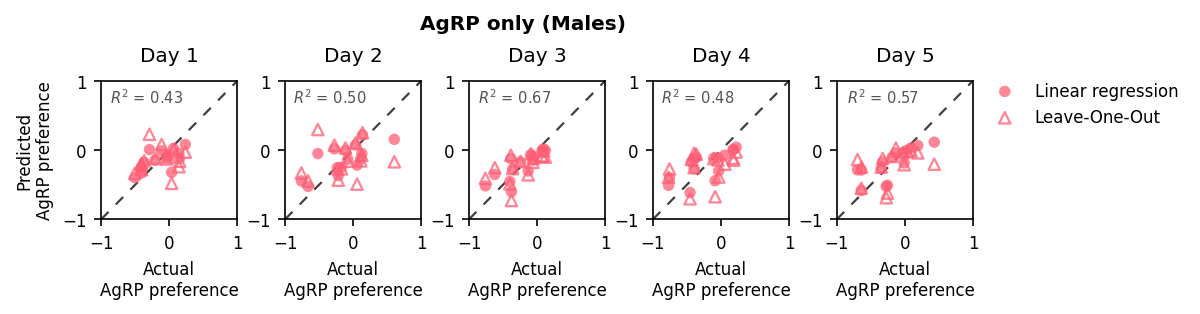

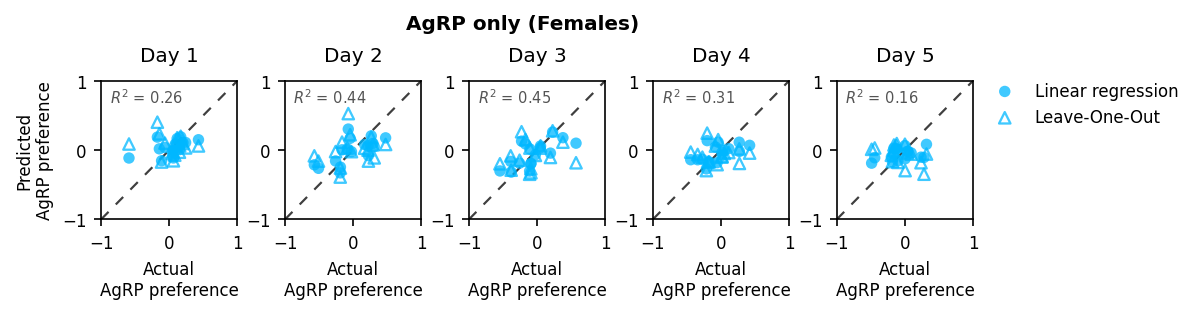

In [6]:
regress, regress_looc = {}, {}
for sex in ['male', 'female']: 
    temp_regress, temp_looc = [], []
    
    fig, axs = plt.subplots(1,5, figsize=(5*1.5,1.2), dpi=150)
    fig.subplots_adjust(wspace=0.35)
    fig.suptitle(f"AgRP only ({sex[0].upper()}{sex[1:]}s)", y=1.25, ha='center', fontweight='bold')

    """
    Variables to select for the linear model:
    1. AgRP stim-triggered amount of food
    2. Weight prior to the feeding test
    3. EPM score (open arm occupancy)
    4. Bias towards the visual cues
    """
    columns = [('feeding','amount'), ('feeding','weight'), ('epm','ratio'), ('bias',0)]
    data_df.loc[:, ('bias',0)] = data_df['baseline'].mean(axis=1) # Add bias as mean of the baseline days
    for d, day in enumerate([1,2,3,4,5]):
        df = data_df.query("@data_df.mouse.sex==@sex").sort_values(('test',day))
        X = df.loc[:, columns].to_numpy()
        y = df.loc[:, ('test',day)].to_numpy()

        # Normalize the input data
        scaler = StandardScaler(with_mean=True, with_std=True)
        X = scaler.fit_transform(X)

        # Ridge regression
        reg = Ridge().fit(X, y)
        y_predict = reg.predict(X) # Predict

        # Calculate and store metrics for the linear regression
        R2, r2, mse = getMetrics(reg, X, y, y_predict) # Get metrics
        temp_regress.append(pd.DataFrame({'mse':mse, 'r2':r2, 'R2':R2}, index=[day]))

        ax = axs[d]

        ax.text(x=0.2, y=0.9, s=r'$R^2$'+f' = {R2:.2f}', ha='right', va='top', fontsize=7, color=colors['darkgray'])
        
        ax.scatter(y, y_predict, clip_on=False, marker='o', linewidth=0, s=30, 
                   edgecolors='None', facecolors=colors[sex], alpha=0.75, 
                   label='Linear regression')
        ax.plot([-1,1], [-1,1], linewidth=1, color='k', linestyle=(0,(5,5)), alpha=0.5, zorder=-1)

        # Leave-One-Out Crossvalidation (LOOC)
        kf = KFold(n_splits=len(y), shuffle=False, random_state=None)
        kf.get_n_splits(X)
        
        y_predict_looc = []
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            reg_looc = Ridge().fit(X_train, y_train)
            y_predict_ = reg_looc.predict(X_test) # Predict
            
            y_predict_looc = np.append(y_predict_looc, y_predict_)

        ax.set_title(f"Day {day}", y=1.05, ha='center')

        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])

        ax.set_xticks([-1,0,1])
        ax.set_yticks([-1,0,1])

        if day==1: ax.set_ylabel('Predicted\nAgRP preference', ha='center')
        ax.set_xlabel('Actual\nAgRP preference', ha='center')

        ax.scatter(y, y_predict_looc, clip_on=False, marker='^', linewidth=1.1, s=30, 
                   edgecolors=colors[sex], facecolors='None', alpha=0.75, 
                   label='Leave-One-Out')
        ax.plot([-1,1], [-1,1], linewidth=1, color='k', linestyle=(0,(5,5)), alpha=0.5, zorder=-1)

        # Calculate and store metrics for LOOC
        R2_looc, r2_looc, mse_looc = getMetrics(reg_looc, X, y, y_predict_looc) # Get metrics for LOOC
        temp_looc.append(pd.DataFrame({'mse':mse_looc,'r2':r2_looc,'R2':R2_looc}, index=[day]))
        
    h, l = ax.axes.get_legend_handles_labels()
    lg = axs[-1].legend(h[:2], l[:2], frameon=False, bbox_to_anchor=(1,1.1))
    
    regress[sex] = pd.concat(temp_regress)
    regress_looc[sex] = pd.concat(temp_looc)
    

### Plot linear regression metrics 

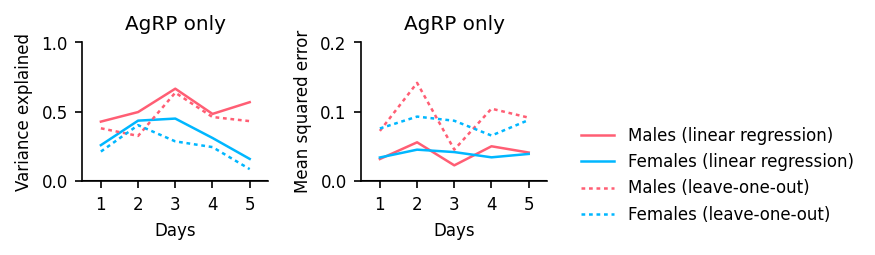

In [7]:
# AgRP only
# Plot variance explained
fig, axs = plt.subplots(1,2, figsize=(2*2,1.2), dpi=150)
fig.subplots_adjust(wspace=0.5)

for i, metric in enumerate(['R2', 'mse']):
    ax = axs[i]

    regress['male'][metric].plot(ax=ax, linewidth=1.2, color=colors['male'], label='Males (linear regression)')
    regress['female'][metric].plot(ax=ax, linewidth=1.2, color=colors['female'], label='Females (linear regression)')
    regress_looc['male'][metric].plot(ax=ax, linewidth=1.2, linestyle=(0,(1.5,1.5)), color=colors['male'], label='Males (leave-one-out)')
    regress_looc['female'][metric].plot(ax=ax, linewidth=1.2, linestyle=(0,(1.5,1.5)), color=colors['female'], label='Females (leave-one-out)')

    ax.plot([0,6], [0,0], linewidth=1, color='k', zorder=-1)

    ax.set_xlim([0.5,5.5])
    ax.set_xlabel('Days', ha='center')

    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5])

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    if metric=='R2':
        ax.set_ylim([0,1])
        ax.set_yticks([0,0.5,1])
        ax.set_ylabel('Variance explained', ha='center')
        ax.set_title('AgRP only', ha='center')
    elif metric=='mse':
        ax.set_ylim([0,0.2])
        ax.set_yticks([0,0.1,0.2])
        ax.set_ylabel('Mean squared error', ha='center')
        ax.set_title('AgRP only', ha='center') 

axs[-1].legend(labels=['Males (linear regression)','Females (linear regression)',
                       'Males (leave-one-out)', 'Females (leave-one-out)'], frameon=False, bbox_to_anchor=(1.1,0.5))


#### AgRP + stress

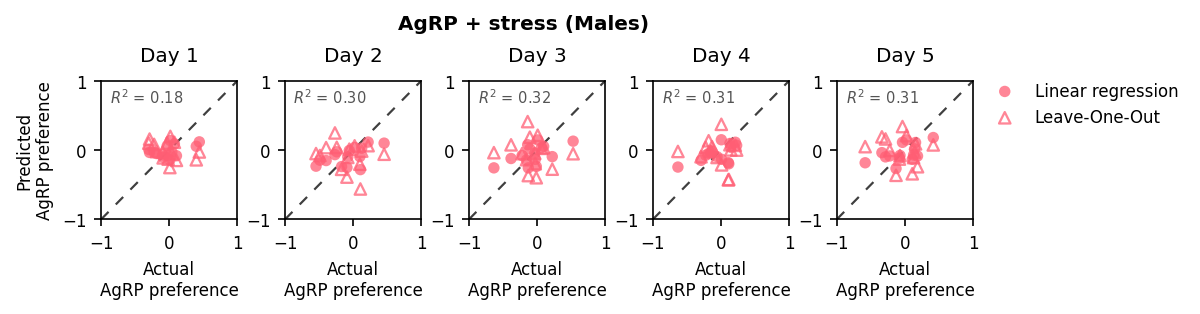

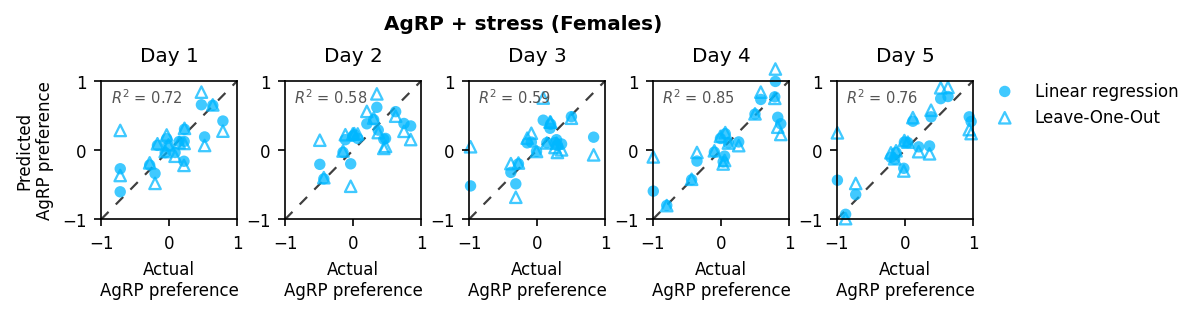

In [8]:
regress, regress_looc = {}, {}
for sex in ['male', 'female']: 
    temp_regress, temp_looc = [], []
    
    fig, axs = plt.subplots(1,5, figsize=(5*1.5,1.2), dpi=150)
    fig.subplots_adjust(wspace=0.35)
    fig.suptitle(f"AgRP + stress ({sex[0].upper()}{sex[1:]}s)", y=1.25, ha='center', fontweight='bold')

    """
    Variables to select for the linear model:
    1. AgRP stim-triggered amount of food
    2. Weight prior to the feeding test
    3. EPM score (open arm occupancy)
    4. Change in OFT score (center zone occupancy)
    5. AgRP preference on day 5 of RTPP prior to stress induction
    """
    columns = [('feeding','amount'), ('feeding','weight'), ('epm','ratio'), ('oft','change'), ('test',5)]
    for d, day in enumerate([1,2,3,4,5]):
        df = data_df.query("@data_df.mouse.sex==@sex").sort_values(('test_',day))
        X = df.loc[:, columns].to_numpy()
        y = df.loc[:, ('test_',day)].to_numpy()

        # Normalize the input data
        scaler = StandardScaler(with_mean=True, with_std=True)
        X = scaler.fit_transform(X)

        # Ridge regression
        reg = Ridge().fit(X, y)
        y_predict = reg.predict(X) # Predict

        # Calculate and store metrics for the linear regression
        R2, r2, mse = getMetrics(reg, X, y, y_predict) # Get metrics
        temp_regress.append(pd.DataFrame({'mse':mse, 'r2':r2, 'R2':R2}, index=[day]))

        ax = axs[d]

        ax.text(x=0.2, y=0.9, s=r'$R^2$'+f' = {R2:.2f}', ha='right', va='top', fontsize=7, color=colors['darkgray'])
        
        ax.scatter(y, y_predict, clip_on=False, marker='o', linewidth=0, s=30, 
                   edgecolors='None', facecolors=colors[sex], alpha=0.75, 
                   label='Linear regression')
        ax.plot([-1,1], [-1,1], linewidth=1, color='k', linestyle=(0,(5,5)), alpha=0.5, zorder=-1)

        # Leave-One-Out Crossvalidation (LOOC)
        kf = KFold(n_splits=len(y), shuffle=False, random_state=None)
        kf.get_n_splits(X)
        
        y_predict_looc = []
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            reg_looc = Ridge().fit(X_train, y_train)
            y_predict_ = reg_looc.predict(X_test) # Predict
            
            y_predict_looc = np.append(y_predict_looc, y_predict_)

        ax.set_title(f"Day {day}", y=1.05, ha='center')

        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])

        ax.set_xticks([-1,0,1])
        ax.set_yticks([-1,0,1])

        if day==1: ax.set_ylabel('Predicted\nAgRP preference', ha='center')
        ax.set_xlabel('Actual\nAgRP preference', ha='center')

        ax.scatter(y, y_predict_looc, clip_on=False, marker='^', linewidth=1.1, s=30, 
                   edgecolors=colors[sex], facecolors='None', alpha=0.75, 
                   label='Leave-One-Out')
        ax.plot([-1,1], [-1,1], linewidth=1, color='k', linestyle=(0,(5,5)), alpha=0.5, zorder=-1)

        # Calculate and store metrics for LOOC
        R2_looc, r2_looc, mse_looc = getMetrics(reg_looc, X, y, y_predict_looc) # Get metrics for LOOC
        temp_looc.append(pd.DataFrame({'mse':mse_looc,'r2':r2_looc,'R2':R2_looc}, index=[day]))
        
    h, l = ax.axes.get_legend_handles_labels()
    lg = axs[-1].legend(h[:2], l[:2], frameon=False, bbox_to_anchor=(1,1.1))
    
    regress[sex] = pd.concat(temp_regress)
    regress_looc[sex] = pd.concat(temp_looc)
    

### Plot linear regression metrics 

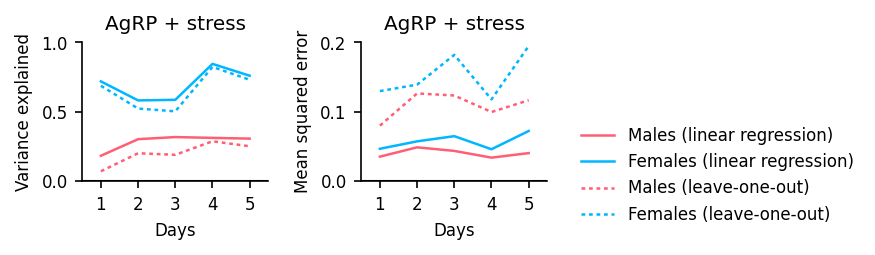

In [9]:
# AgRP + stress
# Plot variance explained
fig, axs = plt.subplots(1,2, figsize=(2*2,1.2), dpi=150)
fig.subplots_adjust(wspace=0.5)

for i, metric in enumerate(['R2', 'mse']):
    ax = axs[i]

    regress['male'][metric].plot(ax=ax, linewidth=1.2, color=colors['male'], label='Males (linear regression)')
    regress['female'][metric].plot(ax=ax, linewidth=1.2, color=colors['female'], label='Females (linear regression)')
    regress_looc['male'][metric].plot(ax=ax, linewidth=1.2, linestyle=(0,(1.5,1.5)), color=colors['male'], label='Males (leave-one-out)')
    regress_looc['female'][metric].plot(ax=ax, linewidth=1.2, linestyle=(0,(1.5,1.5)), color=colors['female'], label='Females (leave-one-out)')

    ax.plot([0,6], [0,0], linewidth=1, color='k', zorder=-1)

    ax.set_xlim([0.5,5.5])
    ax.set_xlabel('Days', ha='center')

    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5])

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    if metric=='R2':
        ax.set_ylim([0,1])
        ax.set_yticks([0,0.5,1])
        ax.set_ylabel('Variance explained', ha='center')
        ax.set_title('AgRP + stress', ha='center')
    elif metric=='mse':
        ax.set_ylim([0,0.2])
        ax.set_yticks([0,0.1,0.2])
        ax.set_ylabel('Mean squared error', ha='center')
        ax.set_title('AgRP + stress', ha='center') 

axs[-1].legend(labels=['Males (linear regression)','Females (linear regression)',
                       'Males (leave-one-out)', 'Females (leave-one-out)'], frameon=False, bbox_to_anchor=(1.1,0.5))


## Figure 3F and 3H

### Subset models for AgRP only

Cells below executes the model fits for all possible subsets of the variables used in the full model. Run the next cells one of the other. For a detailed explanation see *Multiple linear regression analysis* under Methods.

male:   0%|          | 0/4 [00:00<?, ?it/s]

female: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


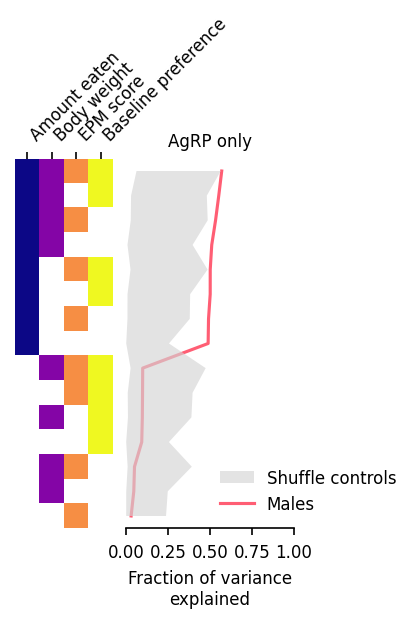

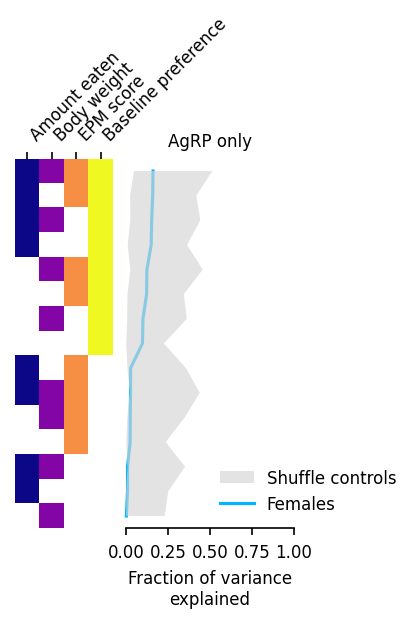

In [10]:
# Best subsets
day = 5
titles = ['Amount eaten', 'Body weight', 'EPM score', 'Baseline preference']

regress = {}
for s, sex in enumerate(['male', 'female']): 
    temp_regress, temp_looc = [], []

    """
    Variables to select for the linear model:
    1. AgRP stim-triggered amount of food
    2. Weight prior to the feeding test
    3. EPM score (open arm occupancy)
    4. Bias towards the visual cues
    """
    cols = [('feeding','amount'), ('feeding','weight'), ('epm','ratio'), ('bias',0)]
    data_df.loc[:, ('bias',0)] = data_df['baseline'].mean(axis=1) # Add bias as mean of the baseline days
    df = data_df.query("@data_df.mouse.sex==@sex").sort_values(('test',day))
    for ncols in tqdm(np.arange(len(cols),0,-1), desc=sex, dynamic_ncols=True, smoothing=1):
        for i, perm in enumerate(combinations(cols, ncols)):
            df = data_df.query("@data_df.mouse.sex==@sex").sort_values(('test',day))
            
            X = df.loc[:, list(perm)].to_numpy()
            y = df.loc[:, ('test',day)].to_numpy()

            # Normalize the input data
            scaler = StandardScaler(with_mean=True, with_std=True)
            X = scaler.fit_transform(X)

            # Linear regression
            reg = Ridge().fit(X, y)
            y_predict = reg.predict(X) # Predict
            R2, r2, mse = getMetrics(reg, X, y, y_predict) # Get metrics

            R2_shuffle, r2_shuffle, mse_shuffle, corr_shuffle = [], [], [], []
            for n in range(1000):
                rng = np.random.default_rng()
                rng.shuffle(X, axis=0)
                reg = Ridge().fit(X, y)
                y_predict_shuffle = reg.predict(X) # Predict
                R2_, r2_, mse_ = getMetrics(reg, X, y, y_predict_shuffle) # Get metrics
                R2_shuffle.append(R2_)
                r2_shuffle.append(r2_)
                mse_shuffle.append(mse_)
                corr_shuffle.append(pearsonr(y, y_predict_shuffle)[0])
            R2_lo, R2_hi = np.quantile(R2_shuffle, [0.05, 0.95])
            corr_lo, corr_hi = np.quantile(corr_shuffle, [0.05, 0.95])
            mse_lo, mse_hi = np.quantile(mse_shuffle, [0.05, 0.95])

            temp_regress.append(pd.DataFrame({'features':[list(perm)], 'l':len(perm),
                                      'corr':pearsonr(y, y_predict)[0], 'pear_p':pearsonr(y, y_predict)[1],
                                      'corr_lo':corr_lo, 'corr_hi':corr_hi,'corr_shuffle':[corr_shuffle],
                                      'mse':mse, 'mse_lo':mse_lo, 'mse_hi':mse_hi, 'mse_shuffle':[mse_shuffle], 
                                      'R2':R2, 'R2_lo':R2_lo, 'R2_hi':R2_hi, 'R2_shuffle':[R2_shuffle]}, index=[0]))

    regress[sex] = pd.concat(temp_regress).reset_index(drop=True)
    regress_agrp = regress.copy()
    
    # Get what you want to plot from the data table
    regress_df = regress[sex].copy()
    indx = np.argsort(regress_df['R2']).to_numpy()
    regress_df = regress_df.reindex(indx)

    # Make the plots
    fig, axs = plt.subplots(1,2, figsize=(2*1.2,2*1.6), dpi=150, gridspec_kw={'width_ratios':[3.5,6]})
    fig.subplots_adjust(wspace=0.1)
    
    # Plot bestsubsets
    ax = axs[1]
    ax.set_title(f"AgRP only", y=1.0, ha='center', fontsize=8)
    ax.set_xlabel("Fraction of variance\nexplained")
    
    ax.set_ylim([0-0.5, len(regress_df)-1+0.5])
    ax.set_xlim([0,1])
    ax.set_xticks(np.arange(0,1.1,0.25))

    R2 = regress_df['R2']
    inds = regress_df.reset_index(drop=True).index
    hi_bound = regress_df['R2_hi'].to_numpy()
    lo_bound = regress_df['R2_lo'].to_numpy()

    ax.fill_betweenx(inds, hi_bound, lo_bound, facecolor=colors['gray'], linewidth=0, alpha=0.65, 
                     zorder=1, clip_on=False, label='Shuffle controls')
    ax.plot(R2, inds, color=colors[sex], linewidth=1.5, zorder=-1, clip_on=False, label=f'{sex[0].upper()}{sex[1:]}s')
    
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['left'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)

    ax.legend(bbox_to_anchor=(1.7,0), frameon=False, loc='lower right')
    
    # Plot colored feature labels
    ax = axs[0]
    
    cmap_df = []
    for r, row in regress_df['features'].items():
        mask = [[c for c, col in enumerate(cols) if col==colname][0] for colname in row]
        arr = np.zeros(regress_df['l'].max())
        arr[:] = np.nan
        arr[mask] = mask

        temp_df = pd.DataFrame({f"{cols[c]}":[arr[c]] for c in range(len(arr))})
        cmap_df.append(temp_df)
    cmap_df = pd.concat(cmap_df, ignore_index=True)

    # Plot the color coded labels
    ax.imshow(cmap_df, cmap=cmap, aspect='auto', interpolation='none', origin='lower')

    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(titles, rotation=45, ha='left')


### Assessment of the varaible contributions for AgRP only

Contribution of each variable to the full model is assesed below. Following cell requires the previous cells output. For a detailed explanation see *Multiple linear regression analysis* under Methods.

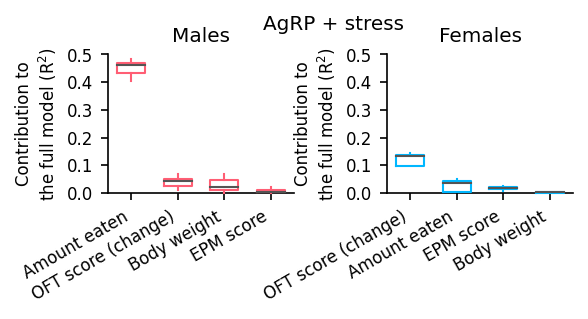

In [11]:
# AgRP only
# Variable contributions
"""
Variables to select for the linear model:
1. AgRP stim-triggered amount of food
2. Weight prior to the feeding test
3. EPM score (open arm occupancy)
4. Bias towards the visual cues
"""
columns = [('feeding','amount'), ('feeding','weight'), ('epm','ratio'), ('bias',0)]
data_df.loc[:, ('bias',0)] = data_df['baseline'].mean(axis=1) # Add bias as mean of the baseline days
titles = ['Amount eaten', 'Body weight', 'EPM score', 'OFT score (change)', 'AgRP only preference']
titles = {columns[i]:titles[i] for i in range(len(columns))}

fig, axs = plt.subplots(1,2,figsize=(4,1.2),dpi=150,facecolor='w')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("AgRP + stress", ha='center', y=1.1)

for s, sex in enumerate(['male','female']):
    columns = regress_agrp[sex].loc[0, 'features']
    drop = {col:[] for col in columns}
    for i in np.arange(len(columns),1,-1):
        for combs in combinations(columns, i):
            feats = [ft for ft in regress_agrp[sex].loc[:, 'features'] if ft==list(combs)][0]
            idx_ = [ind for ind,a in regress_agrp[sex]['features'].iteritems() if a==feats]
            full_score = regress_agrp[sex].loc[idx_, 'R2']
            for ft in feats:
                arr = [a for a in feats if a!=ft]
                idx = [ind for ind,a in regress_agrp[sex]['features'].iteritems() if a==arr][0]

                drop[ft] = np.append(drop[ft], full_score - regress_agrp[sex].loc[idx, 'R2'])

    drop = pd.DataFrame(drop)
    drop = drop.reindex(drop.mean().sort_values(ascending=False).index, axis=1)


    ax = axs[s]
    
    ax.boxplot(drop, positions=np.arange(len(drop.columns)), 
               boxprops={'color':colors[sex], 'clip_on':False},
               medianprops={'color':colors['darkgray'], 'clip_on':False},
               whiskerprops={'color':colors[sex], 'clip_on':False},
               showfliers=False,whis=[0,100],
               widths=0.6, showcaps=False, zorder=99);
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel("Contribution to\nthe full model (R$^2$)")
        
    ax.set_ylim([0,0.5])
    ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
    
    ax.set_xlim([-0.5,len(drop.columns)-0.5])
    ax.set_xticks(np.arange(len(drop.columns)))
    ax.set_xticklabels([titles[c] for c in drop.columns], rotation=30, ha='right')
        
    ax.set_title(f"{sex.upper()[0]}{sex[1:]}s")

## Figure 3G and 3I

### Subset models for AgRP + stress

female: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


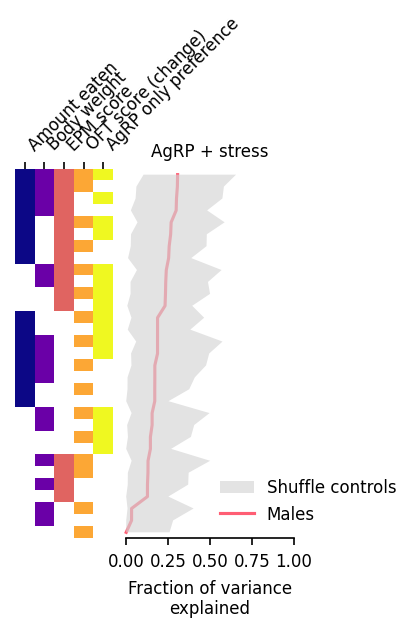

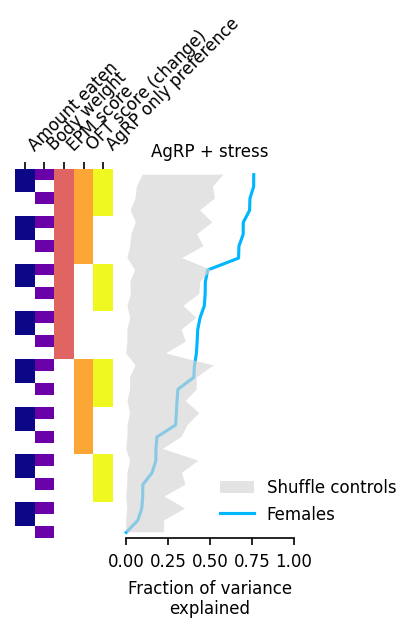

In [12]:
# Best subsets
day = 5
titles = ['Amount eaten', 'Body weight', 'EPM score', 'OFT score (change)', 'AgRP only preference']

regress = {}
for s, sex in enumerate(['male', 'female']): 
    temp_regress, temp_looc = [], []
    
    """
    Variables to select for the linear model:
    1. AgRP stim-triggered amount of food
    2. Weight prior to the feeding test
    3. EPM score (open arm occupancy)
    4. Change in OFT score (center zone occupancy)
    5. AgRP preference on day 5 of RTPP prior to stress induction
    """
    cols = [('feeding','amount'), ('feeding','weight'), ('epm','ratio'), ('oft','change'), ('test',5)]
    df = data_df.query("@data_df.mouse.sex==@sex").sort_values(('test_',day))
    for ncols in tqdm(np.arange(len(cols),0,-1), desc=sex, dynamic_ncols=True, smoothing=1):
        for i, perm in enumerate(combinations(cols, ncols)):
            df = data_df.query("@data_df.mouse.sex==@sex").sort_values(('test_',day))
            
            X = df.loc[:, list(perm)].to_numpy()
            y = df.loc[:, ('test_',day)].to_numpy()

            # Normalize the input data
            scaler = StandardScaler(with_mean=True, with_std=True)
            X = scaler.fit_transform(X)

            # Linear regression
            reg = Ridge().fit(X, y)
            y_predict = reg.predict(X) # Predict
            R2, r2, mse = getMetrics(reg, X, y, y_predict) # Get metrics

            R2_shuffle, r2_shuffle, mse_shuffle, corr_shuffle = [], [], [], []
            for n in range(1000):
                rng = np.random.default_rng()
                rng.shuffle(X, axis=0)
                reg = Ridge().fit(X, y)
                y_predict_shuffle = reg.predict(X) # Predict
                R2_, r2_, mse_ = getMetrics(reg, X, y, y_predict_shuffle) # Get metrics
                R2_shuffle.append(R2_)
                r2_shuffle.append(r2_)
                mse_shuffle.append(mse_)
                corr_shuffle.append(pearsonr(y, y_predict_shuffle)[0])
            R2_lo, R2_hi = np.quantile(R2_shuffle, [0.05, 0.95])
            corr_lo, corr_hi = np.quantile(corr_shuffle, [0.05, 0.95])
            mse_lo, mse_hi = np.quantile(mse_shuffle, [0.05, 0.95])

            temp_regress.append(pd.DataFrame({'features':[list(perm)], 'l':len(perm),
                                      'corr':pearsonr(y, y_predict)[0], 'pear_p':pearsonr(y, y_predict)[1],
                                      'corr_lo':corr_lo, 'corr_hi':corr_hi,'corr_shuffle':[corr_shuffle],
                                      'mse':mse, 'mse_lo':mse_lo, 'mse_hi':mse_hi, 'mse_shuffle':[mse_shuffle], 
                                      'R2':R2, 'R2_lo':R2_lo, 'R2_hi':R2_hi, 'R2_shuffle':[R2_shuffle]}, index=[0]))

    regress[sex] = pd.concat(temp_regress).reset_index(drop=True)
    regress_stress = regress.copy()
    
    # Get what you want to plot from the data table
    regress_df = regress[sex].copy()
    indx = np.argsort(regress_df['R2']).to_numpy()
    regress_df = regress_df.reindex(indx)

    # Make the plots
    fig, axs = plt.subplots(1,2, figsize=(2*1.2,2*1.6), dpi=150, gridspec_kw={'width_ratios':[3.5,6]})
    fig.subplots_adjust(wspace=0.1)
    
    # Plot bestsubsets
    ax = axs[1]
    ax.set_title(f"AgRP + stress", y=1.0, ha='center', fontsize=8)
    ax.set_xlabel("Fraction of variance\nexplained")
    
    ax.set_ylim([0-0.5, len(regress_df)-1+0.5])
    ax.set_xlim([0,1])
    ax.set_xticks(np.arange(0,1.1,0.25))

    R2 = regress_df['R2']
    inds = regress_df.reset_index(drop=True).index
    hi_bound = regress_df['R2_hi'].to_numpy()
    lo_bound = regress_df['R2_lo'].to_numpy()

    ax.fill_betweenx(inds, hi_bound, lo_bound, facecolor=colors['gray'], linewidth=0, alpha=0.65, 
                     zorder=1, clip_on=False, label='Shuffle controls')
    ax.plot(R2, inds, color=colors[sex], linewidth=1.5, zorder=-1, clip_on=False, label=f'{sex[0].upper()}{sex[1:]}s')
    
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['left'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)

    ax.legend(bbox_to_anchor=(1.7,0), frameon=False, loc='lower right')
 
    # Plot colored feature labels
    ax = axs[0]
    
    cmap_df = []
    for r, row in regress_df['features'].items():
        mask = [[c for c, col in enumerate(cols) if col==colname][0] for colname in row]
        arr = np.zeros(regress_df['l'].max())
        arr[:] = np.nan
        arr[mask] = mask

        temp_df = pd.DataFrame({f"{cols[c]}":[arr[c]] for c in range(len(arr))})
        cmap_df.append(temp_df)
    cmap_df = pd.concat(cmap_df, ignore_index=True)

    # Plot the color coded labels
    ax.imshow(cmap_df, cmap=cmap, aspect='auto', interpolation='none', origin='lower')

    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(titles, rotation=45, ha='left')
    

### Assessment of the varaible contributions for AgRP + stress

Contribution of each variable to the full model is assesed below. Following cell requires the previous cells output. For a detailed explanation see *Multiple linear regression analysis* under Methods.

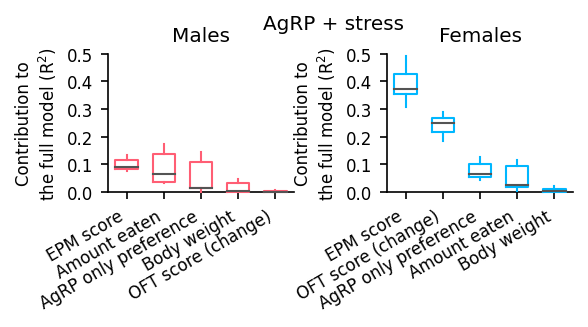

In [13]:
# AgRP + stress
# Variable contributions
"""
Variables to select for the linear model:
1. AgRP stim-triggered amount of food
2. Weight prior to the feeding test
3. EPM score (open arm occupancy)
4. Change in OFT score (center zone occupancy)
5. AgRP preference on day 5 of RTPP prior to stress induction
"""
columns = [('feeding','amount'), ('feeding','weight'), ('epm','ratio'), ('oft','change'), ('test',5)]
titles = ['Amount eaten', 'Body weight', 'EPM score', 'OFT score (change)', 'AgRP only preference']
titles = {columns[i]:titles[i] for i in range(len(columns))}

fig, axs = plt.subplots(1,2,figsize=(4,1.2),dpi=150,facecolor='w')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("AgRP + stress", ha='center', y=1.1)

for s, sex in enumerate(['male','female']):
    columns = regress_stress[sex].loc[0, 'features']
    drop = {col:[] for col in columns}
    for i in np.arange(len(columns),1,-1):
        for combs in combinations(columns, i):
            feats = [ft for ft in regress_stress[sex].loc[:, 'features'] if ft==list(combs)][0]
            idx_ = [ind for ind,a in regress_stress[sex]['features'].iteritems() if a==feats]
            full_score = regress_stress[sex].loc[idx_, 'R2']
            for ft in feats:
                arr = [a for a in feats if a!=ft]
                idx = [ind for ind,a in regress_stress[sex]['features'].iteritems() if a==arr][0]

                drop[ft] = np.append(drop[ft], full_score - regress_stress[sex].loc[idx, 'R2'])

    drop = pd.DataFrame(drop)
    drop = drop.reindex(drop.mean().sort_values(ascending=False).index, axis=1)


    ax = axs[s]
    
    ax.boxplot(drop, positions=np.arange(len(drop.columns)), 
               boxprops={'color':colors[sex], 'clip_on':False},
               medianprops={'color':colors['darkgray'], 'clip_on':False},
               whiskerprops={'color':colors[sex], 'clip_on':False},
               showfliers=False,whis=[0,100],
               widths=0.6, showcaps=False, zorder=99);
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel("Contribution to\nthe full model (R$^2$)")
        
    ax.set_ylim([0,0.5])
    ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
    
    ax.set_xlim([-0.5,len(drop.columns)-0.5])
    ax.set_xticks(np.arange(len(drop.columns)))
    ax.set_xticklabels([titles[c] for c in drop.columns], rotation=30, ha='right')
        
    ax.set_title(f"{sex.upper()[0]}{sex[1:]}s")
    